## Hidden Markov Models

In [162]:
from __future__ import print_function, division
%matplotlib inline

# import used packages and modules
# import display function to display the table of the pandas dataframe
from IPython.display import display

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

from scipy import signal

from hmmlearn import hmm
from seqlearn.hmm import MultinomialHMM

import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import csv


In [163]:
data_dir = '../data/meadows_december/'

data04 = pd.read_csv(data_dir+'meadows-2017-12-04.csv')
data05 = pd.read_csv(data_dir+'meadows-2017-12-05.csv')
data06 = pd.read_csv(data_dir+'meadows-2017-12-06.csv')
data07 = pd.read_csv(data_dir+'meadows-2017-12-07.csv')
data08 = pd.read_csv(data_dir+'meadows-2017-12-08.csv')

meadows_data = pd.concat([data04, data05, data06, data07, data08])
data04['label']=1
data05['label']=1
data06['label']=1
data07['label']=1
data08['label']=1
training_data = pd.concat([data04, data05])
test_data = pd.concat([data06, data07, data08])


In [164]:
display(meadows_data)

,phoneTimestamp,pm1,pm2_5,pm10,temperature,humidity,bin0,bin1,bin2,bin3,...,bin11,bin12,bin13,bin14,bin15,total,gpsLongitude,gpsLatitude,gpsAltitude,gpsAccuracy
0,1512412799389,0.000000,0.000000,0.000000,NaN,NaN,12336,0,0,0,...,0,0,0,0,0,12336,-3.183947,55.945227,137.0,8.0
1,1512412820119,0.000000,0.000000,0.000000,17.000000,51.400000,0,0,0,0,...,0,0,0,0,0,0,-3.183896,55.945287,141.0,10.0
2,1512414079425,0.000000,0.000000,0.000000,17.600000,54.500000,12336,0,0,0,...,0,0,0,0,0,12336,-3.183945,55.945292,143.0,38.0
3,1512414080717,0.000000,0.000000,0.000000,17.500000,54.500000,12336,0,0,0,...,0,0,0,0,0,12336,-3.183945,55.945292,143.0,38.0
4,1512414099538,0.000000,0.000000,0.000000,17.500000,54.500000,0,0,0,0,...,0,0,0,0,0,0,-3.183979,55.945296,142.0,14.0
5,1512414120293,33.472490,40.908604,41.178135,17.400000,54.700000,3247,1148,504,135,...,0,0,0,0,0,5068,-3.184082,55.945118,138.0,6.0
6,1512414141703,11.779354,15.713491,16.466698,17.100000,51.000000,966,409,258,108,...,0,0,0,0,0,1780,-3.184135,55.944876,142.0,12.0
7,1512414161821,4.005422,5.602231,6.469329,16.800001,50.300000,352,115,100,45,...,0,0,0,0,0,639,-3.183867,55.944693,158.0,8.0
8,1512414181925,1.454933,2.256311,10.667744,16.400000,50.900000,137,40,25,20,...,2,0,0,0,0,249,-3.183715,55.944409,151.0,8.0
9,1512414204628,1.212938,1.813488,3.479011,16.000000,51.400000,119,33,19,20,...,0,0,0,0,0,213,-3.183429,55.943987,140.0,7.0


## Indoor Outdoor

In [165]:
out_in = pd.read_csv('../data/indoor-outdoor.csv')
kitchen_data = pd.read_csv('../data/kitchen-data.csv')

In [166]:
bin_vals = ['bin'+str(x) for x in range(16)]

In [167]:
training_data_in = out_in[403:]
training_data_in = training_data_in[training_data_in['label']==0]
kitchen_data['label'] = 0
test_data_in = kitchen_data

In [168]:
training_data_out = out_in[out_in['label']==1]

In [169]:
training_data = pd.concat([training_data_in, training_data_out], ignore_index=True)

In [170]:
test_data = pd.concat([test_data, test_data_in], ignore_index=True)

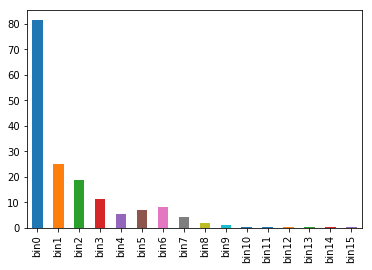

In [171]:
training_data_in[bin_vals].describe().loc['mean'].plot(kind='bar')

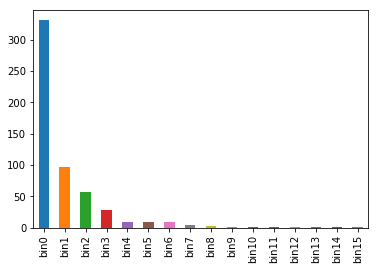

In [181]:
training_data_out[bin_vals].describe().loc['mean'].plot(kind='bar')

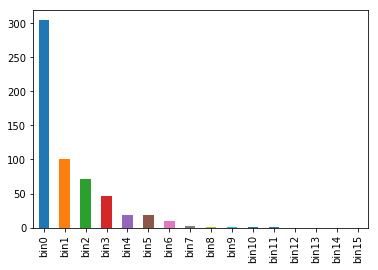

In [182]:
test_data[bin_vals].describe().loc['mean'].plot(kind='bar')

In [190]:
# filter training data with null bin values on all columns
training_data = training_data[training_data['bin0']>0]
training_data[bin_vals] = training_data[bin_vals].apply(lambda row: row/np.sum(row), axis=1)
training_data[bin_vals].describe().loc['mean'].plot(kind='bar')

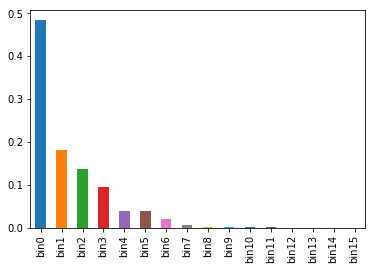

In [192]:
# filter test data with null bin values on all columns
test_data = test_data[test_data['bin0']>0]
test_data[bin_vals] = test_data[bin_vals].apply(lambda row: row/np.sum(row), axis=1)
test_data[bin_vals].describe().loc['mean'].plot(kind='bar')

In [193]:
hmm = MultinomialHMM()
hmm.fit(filtered_training_bins, training_data['label'], 1)
hmm.score(filtered_test_bins, test_data['label'])

0.27308707124010556

In [194]:
gaussian = GaussianNB()

gaussian.fit(filtered_training_bins, training_data['label'])
gaussian.score(filtered_test_bins, test_data['label'])

0.023746701846965697

In [195]:
svc = SVC(kernel='rbf')

svc.fit(filtered_training_bins, training_data['label'])
svc.score(filtered_test_bins, test_data['label'])

0.27308707124010556

## Meadows bike data

In [197]:
meadows_bike = pd.read_csv('../data/misc/20150616.csv')
meadows_bike

,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,bin6,...,pm10,opctemp,temperature,humidity,alphaVersion,urban_space,o3_ae,o3_we,no2_ae,no2_we
0,20150616112722,55.945785,-3.189369,17,0,2,1,1,0,0,...,258.415800,NaN,25.01,42.086746,2,0,27682,27682,23074,27682
1,20150616112723,55.945786,-3.189372,8,1,4,1,2,0,0,...,3.601208,NaN,25.02,41.988818,2,0,27682,27938,22818,26914
2,20150616112724,55.945785,-3.189375,12,0,0,1,1,0,1,...,7.248941,NaN,25.04,41.923517,2,0,28706,26146,24866,28450
3,20150616112725,55.945783,-3.189374,14,0,0,1,1,1,0,...,3.720839,NaN,25.04,41.890861,2,0,28962,28194,25890,29986
4,20150616112726,55.945782,-3.189373,11,1,1,1,1,0,0,...,34.080612,NaN,25.06,41.858203,2,0,30242,27426,27170,26658
5,20150616112727,55.945783,-3.189373,15,1,1,0,0,2,0,...,4.547224,NaN,25.02,41.825541,2,0,25378,27938,25378,26146
6,20150616112728,55.945781,-3.189370,4,1,0,1,0,1,0,...,2.586585,NaN,25.02,41.760208,2,0,24610,29474,25634,26658
7,20150616112729,55.945780,-3.189369,7,4,3,0,0,1,1,...,23.626814,NaN,25.00,41.727536,2,0,28962,26402,24610,27938
8,20150616112730,55.945778,-3.189367,14,2,0,0,0,1,1,...,7.949301,NaN,24.98,41.727536,2,0,26658,29730,22818,27426
9,20150616112731,55.945777,-3.189365,16,0,3,0,0,1,0,...,3.090121,NaN,24.97,41.727536,2,0,26658,26914,23586,26146


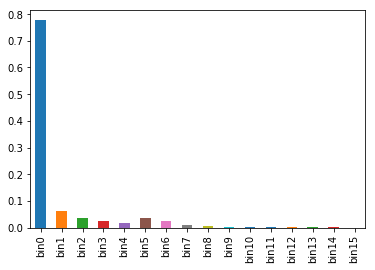

In [198]:
meadows_bike_bins = meadows_bike[bin_vals].apply(lambda row: row/np.sum(row), axis=1)
meadows_bike_bins.describe().loc['mean'].plot(kind='bar')

In [211]:
meadows_bike['label']=2
training = pd.concat([meadows_bike, data04, data05, data06], ignore_index=True)
training = training[training['bin0']>0]
training_bins = training[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

In [221]:
def get_training_accuracy_with_kfolds_iloc(estimator, x_tr, y_tr, kf):
    score_array = np.empty(kf.n_folds)
    
    for (idx, (train_feature, test_feature)) in enumerate(kf):
        estimator.fit(x_tr.iloc[train_feature], y_tr.iloc[train_feature])
        score_array[idx] = estimator.score(x_tr.iloc[test_feature], y_tr.iloc[test_feature])
    
    return np.mean(score_array)

In [222]:
svc = SVC(kernel='rbf')
kf = KFold(len(training_bins), n_folds=3, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(svc, training_bins, training['label'], kf))

Accuracy: 0.865967365967


In [223]:
rf = RandomForestClassifier(random_state=0, n_estimators=50, n_jobs=-1)

kf = KFold(len(training_bins), n_folds=3, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(rf, training_bins, training['label'], kf))

TypeError: fit() missing 1 required positional argument: 'lengths'